In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure

In [5]:
# helper function to plot two images side by side

def plot_side_by_side(img_1, img_2, title1="Original Image", title2="Processed Image"):
    """
    A function to plot two images side by side.
    """
    # if len(img_1.shape) == 3 or len(img_2.shape) == 3:
    #     img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
    #     img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].imshow(img_1, cmap='gray')
    axs[1].imshow(img_2, cmap='gray')

    axs[0].set_title(title1)
    axs[1].set_title(title2)


# function to enhance image contrast
def enhance_contrast(image):
    """Enhance image contrast for better feature detection."""
    # Apply histogram equalization
    return exposure.equalize_hist(image)

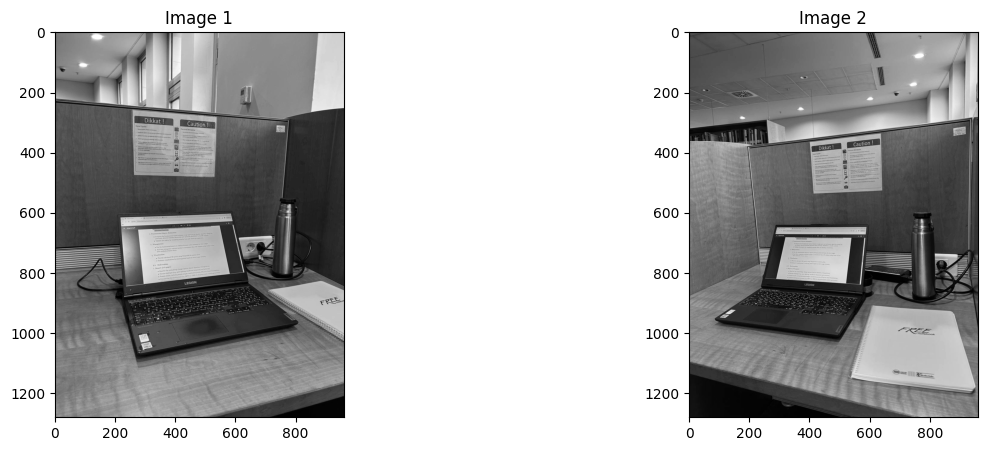

In [7]:
# Load images
img1 = cv2.imread("images/image_1.jpg", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("images/image_2.jpg", cv2.IMREAD_GRAYSCALE)

plot_side_by_side(img1, img2, "Image 1", "Image 2")

In [20]:
# 1. Detect features and match
# we will use SIFT first, and then maybe switch to other methods

def detect_keypoints_and_descriptors(img1_gray, img2_gray, contrast_enhancement=True):
    """Detect keypoints and compute descriptors using SIFT."""
    # Optionally enhance contrast
    if contrast_enhancement:
        img1_gray = enhance_contrast(img1_gray)
        img2_gray = enhance_contrast(img2_gray)

    # Normalize to uint8
    img1_gray = (img1_gray * 255).astype(np.uint8) if img1_gray.dtype != np.uint8 else img1_gray
    img2_gray = (img2_gray * 255).astype(np.uint8) if img2_gray.dtype != np.uint8 else img2_gray

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors
    kp1, des1 = sift.detectAndCompute(img1_gray, None)
    kp2, des2 = sift.detectAndCompute(img2_gray, None)

    return kp1, des1, kp2, des2


def detect_keypoints_and_descriptors_ORB(img1_gray, img2_gray):
    """Detect keypoints and compute descriptors using ORB."""
    # Initialize ORB detector
    orb = cv2.ORB_create()

    # Detect keypoints and compute descriptors
    kp1, des1 = orb.detectAndCompute(img1_gray, None)
    kp2, des2 = orb.detectAndCompute(img2_gray, None)

    if des1 is None or des2 is None or len(kp1) < 10 or len(kp2) < 10:
        raise ValueError("Not enough keypoints detected in one or both images.")

    return kp1, des1, kp2, des2

kp1, des1, kp2, des2 = detect_keypoints_and_descriptors(img1, img2)

# Use FLANN based matcher
index_params = dict(algorithm=1, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

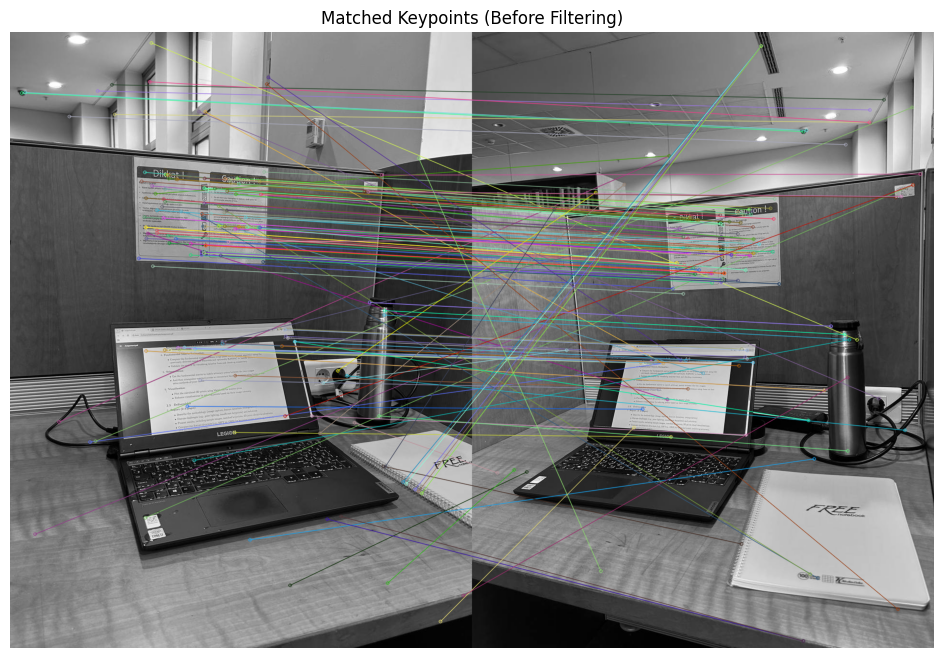

In [9]:
# Apply Lowe's ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Draw matches before geometric filtering
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None,
                              flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(16, 8))
plt.title("Matched Keypoints (Before Filtering)")
plt.imshow(img_matches)
plt.axis("off")
plt.show()

We can see that some keypoints are matched perfectly, like a top of termos bottle. However, other keypoints are bad match

Therefore, we better implement RANSAC to get rid of outliers

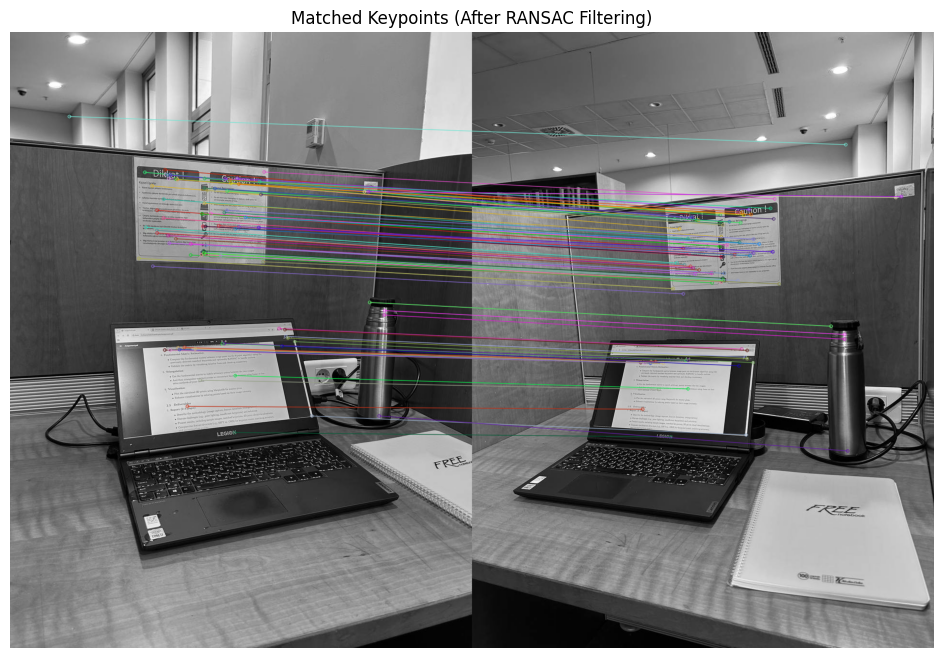

In [10]:
# Extract point coordinates
pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

# Find Fundamental Matrix with RANSAC to reject outliers
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# Select inlier matches
inlier_matches = [good_matches[i] for i in range(len(good_matches)) if mask[i]]

# Draw inlier matches only
img_inlier_matches = cv2.drawMatches(img1, kp1, img2, kp2, inlier_matches, None,
                                     flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(16, 8))
plt.title("Matched Keypoints (After RANSAC Filtering)")
plt.imshow(img_inlier_matches)
plt.axis("off")
plt.show()


Now we will try ORB

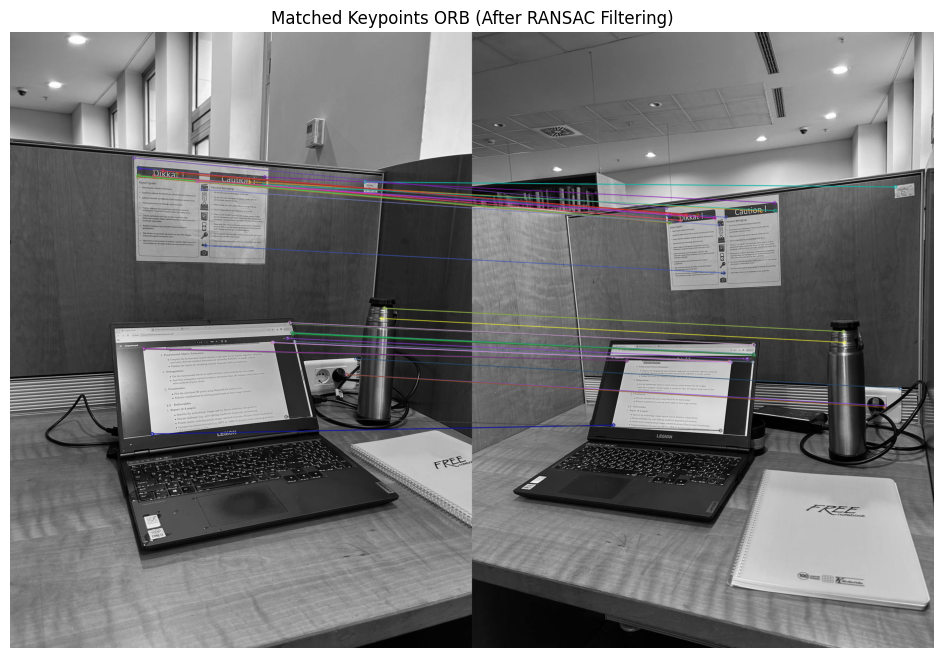

In [24]:
kp1_orb, des1_orb, kp2_orb, des2_orb = detect_keypoints_and_descriptors_ORB(img1, img2)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches_orb = bf.match(des1_orb, des2_orb)

# Sort matches by distance
matches_orb = sorted(matches_orb, key=lambda x: x.distance)

good_matches_orb = matches_orb[:100]  # or use a threshold

matched_img_orb = cv2.drawMatches(img1, kp1_orb, img2, kp2_orb, good_matches_orb, None,
                              flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

pts1_orb = np.float32([kp1_orb[m.queryIdx].pt for m in good_matches_orb])
pts2_orb = np.float32([kp2_orb[m.trainIdx].pt for m in good_matches_orb])

# Find Fundamental Matrix with RANSAC to reject outliers
F_orb, mask_orb = cv2.findFundamentalMat(pts1_orb, pts2_orb, cv2.FM_RANSAC)

# Select inlier matches
inlier_matches_orb = [good_matches_orb[i] for i in range(len(good_matches_orb)) if mask_orb[i]]

# Draw inlier matches only
img_inlier_matches_orb = cv2.drawMatches(img1, kp1_orb, img2, kp2_orb, inlier_matches_orb, None,
                                     flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(16, 8))
plt.title("Matched Keypoints ORB (After RANSAC Filtering)")
plt.imshow(img_inlier_matches_orb)
plt.axis("off")
plt.show()


Matched keypoints with ORB seem to be more accurate, and their number is less 

This is our Fundamental Matrices

In [25]:
print("Fundamental Matrix using SIFT:")
print(F)

print("Fundamental Matrix using ORB:")
print(F_orb)

Fundamental Matrix using SIFT:
[[ 1.10146150e-07  1.21276945e-06 -8.90334206e-04]
 [ 1.00525560e-06 -5.11337139e-08 -3.46277110e-03]
 [-5.40385668e-04  2.08176352e-03  1.00000000e+00]]
Fundamental Matrix using ORB:
[[ 7.38647281e-08  2.08612748e-06 -1.31627810e-03]
 [-8.26168365e-08  2.77434109e-07 -2.91042234e-03]
 [ 1.04771715e-04  1.25112731e-03  1.00000000e+00]]


Now the result looks much better, but we still have bad matches. For example, some pairs at the edge of laptop screen

Let's load camera intrinsic matrix. Camera intrinsic matrix was calculated in separate file called "camera_calibration"

In [26]:
with open("camera_calibration.txt", 'r') as f:
    lines = f.readlines()

K = np.array([[float(x) for x in line.split()] for line in lines[0:3]])
print(K)

[[957.49827124   0.         482.6229717 ]
 [  0.         956.02050829 646.17960381]
 [  0.           0.           1.        ]]


In [14]:
# function to draw epipolar lines

def draw_epipolar_lines(img1, img2, F, pts1, pts2):
    # Convert to color for visualization
    img1_color = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2_color = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

    # Compute epilines in image 1 (from pts2)
    lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F).reshape(-1, 3)
    for r, pt in zip(lines1, pts1):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [img1.shape[1], -(r[2] + r[0]*img1.shape[1])/r[1]])
        img1_color = cv2.line(img1_color, (x0, y0), (x1, y1), color, 1)
        img1_color = cv2.circle(img1_color, tuple(np.round(pt).astype(int)), 5, color, -1)

    # Compute epilines in image 2 (from pts1)
    lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F).reshape(-1, 3)
    for r, pt in zip(lines2, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [img2.shape[1], -(r[2] + r[0]*img2.shape[1])/r[1]])
        img2_color = cv2.line(img2_color, (x0, y0), (x1, y1), color, 1)
        img2_color = cv2.circle(img2_color, tuple(np.round(pt).astype(int)), 5, color, -1)

    return img1_color, img2_color


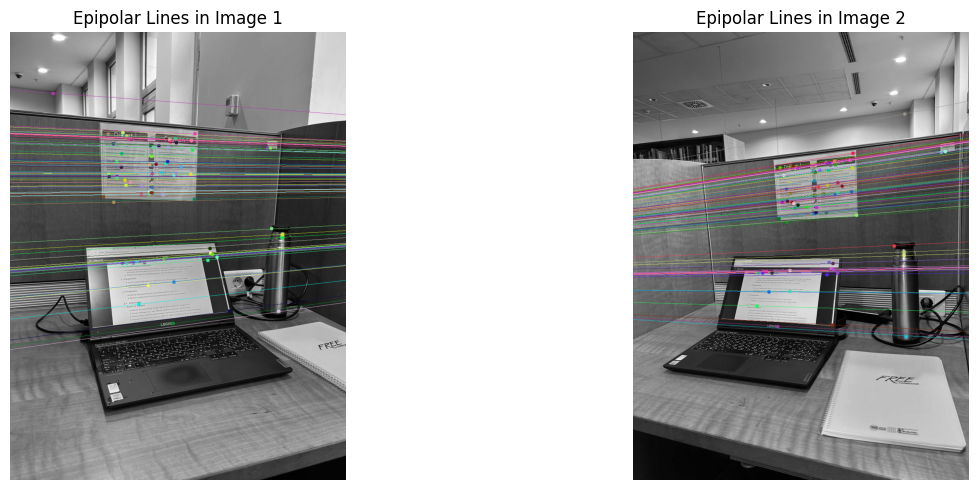

In [15]:
pts1_inliers = pts1[mask.ravel() == 1]
pts2_inliers = pts2[mask.ravel() == 1]

img1_epi, img2_epi = draw_epipolar_lines(img1, img2, F, pts1_inliers, pts2_inliers)

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title("Epipolar Lines in Image 1")
plt.imshow(cv2.cvtColor(img1_epi, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(122)
plt.title("Epipolar Lines in Image 2")
plt.imshow(cv2.cvtColor(img2_epi, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()

Now let's draw epipolar lines for ORB matches 

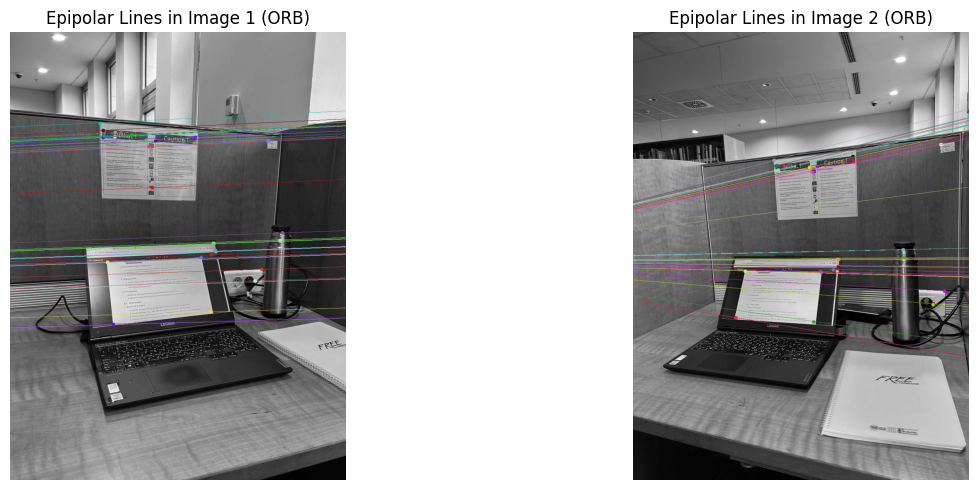

In [28]:
pts1_inliers_orb = pts1_orb[mask_orb.ravel() == 1]
pts2_inliers_orb = pts2_orb[mask_orb.ravel() == 1]

img1_epi_orb, img2_epi_orb = draw_epipolar_lines(img1, img2, F_orb, pts1_inliers_orb, pts2_inliers_orb)

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title("Epipolar Lines in Image 1 (ORB)")
plt.imshow(cv2.cvtColor(img1_epi_orb, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(122)
plt.title("Epipolar Lines in Image 2 (ORB)")
plt.imshow(cv2.cvtColor(img2_epi_orb, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()

In [31]:
def triangulate_and_plot(img1, pts1, pts2, K, R, t, title="3D Reconstruction"):
    """
    Triangulates 3D points from matched 2D points and plots them with intensity coloring.
    
    Args:
        img1 (ndarray): First grayscale image.
        pts1 (ndarray): Matched keypoints from image 1, shape (N, 2).
        pts2 (ndarray): Matched keypoints from image 2, shape (N, 2).
        K (ndarray): Intrinsic matrix (3x3).
        R (ndarray): Rotation matrix from cv2.recoverPose.
        t (ndarray): Translation vector from cv2.recoverPose.
        title (str): Plot title.
    """
    # Undistort and normalize points
    pts1_undist = cv2.undistortPoints(pts1.reshape(-1, 1, 2), K, None)
    pts2_undist = cv2.undistortPoints(pts2.reshape(-1, 1, 2), K, None)

    # Projection matrices
    P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
    P2 = K @ np.hstack((R, t))

    # Triangulate points
    points_4d_hom = cv2.triangulatePoints(P1, P2, pts1_undist, pts2_undist)
    points_3d = (points_4d_hom[:3] / points_4d_hom[3]).T  # shape: (N, 3)

    # Extract image intensities
    pts1_int = np.round(pts1).astype(int)
    h, w = img1.shape
    pts1_int[:, 0] = np.clip(pts1_int[:, 0], 0, w - 1)
    pts1_int[:, 1] = np.clip(pts1_int[:, 1], 0, h - 1)

    intensities = img1[pts1_int[:, 1], pts1_int[:, 0]]
    colors = intensities / 255.0  # normalize

    # 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2],
                    c=colors, cmap='gray', s=3)
    
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.colorbar(sc, label='Normalized Intensity')
    plt.tight_layout()
    plt.show()

    return points_3d  # optional return


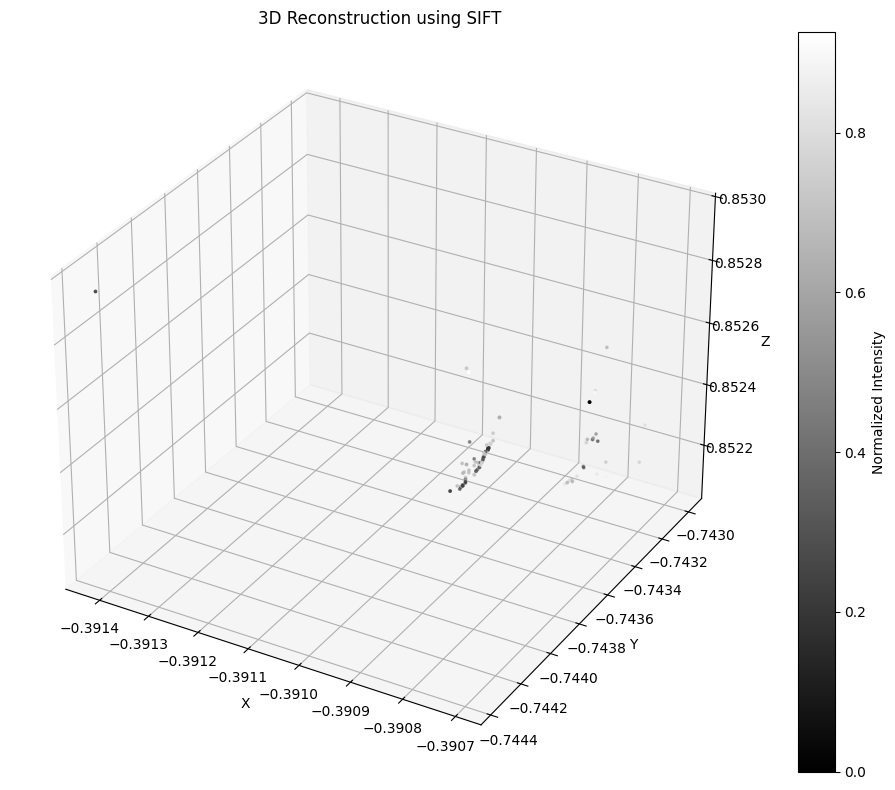

array([[-0.39141786, -0.744363  ,  0.8529475 ],
       [-0.39096007, -0.7435009 ,  0.8522509 ],
       [-0.39096007, -0.7435009 ,  0.8522509 ],
       [-0.3909384 , -0.7436869 ,  0.8522568 ],
       [-0.3909384 , -0.7436869 ,  0.8522568 ],
       [-0.39094672, -0.7435716 ,  0.8522601 ],
       [-0.39094672, -0.7435716 ,  0.8522601 ],
       [-0.39094645, -0.74356383,  0.8522607 ],
       [-0.39093143, -0.7436629 ,  0.85226625],
       [-0.39094648, -0.74349576,  0.85227364],
       [-0.39093462, -0.74357265,  0.85227615],
       [-0.39092922, -0.7436139 ,  0.8522729 ],
       [-0.39094537, -0.74358255,  0.8522973 ],
       [-0.39092547, -0.743605  ,  0.8522865 ],
       [-0.39092076, -0.74364406,  0.85228443],
       [-0.3908489 , -0.7431916 ,  0.8521034 ],
       [-0.39091337, -0.7437078 ,  0.85228497],
       [-0.39091396, -0.7436985 ,  0.85228705],
       [-0.39091206, -0.74370056,  0.8522908 ],
       [-0.39092448, -0.7435721 ,  0.8522958 ],
       [-0.39091206, -0.7436937 ,  0.852

In [34]:
E = K.T @ F @ K
points, R, t, mask_pose = cv2.recoverPose(E, pts1_inliers, pts2_inliers, K)
triangulate_and_plot(img1, pts1_inliers, pts2_inliers, K, R, t, title="3D Reconstruction using SIFT")

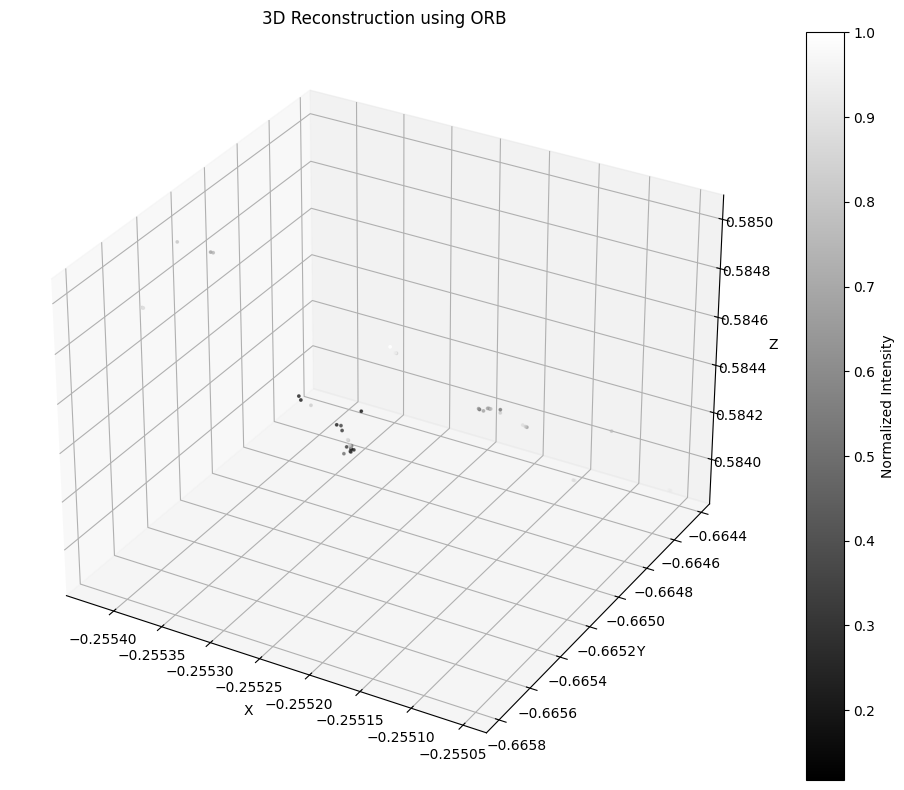

array([[-0.25525665, -0.6652855 ,  0.58434814],
       [-0.25505444, -0.6644356 ,  0.5838896 ],
       [-0.2552606 , -0.6653331 ,  0.58443433],
       [-0.25526407, -0.66521996,  0.5842648 ],
       [-0.25526014, -0.665244  ,  0.5842978 ],
       [-0.25505564, -0.66443837,  0.58389217],
       [-0.25516307, -0.66497254,  0.5844121 ],
       [-0.25515628, -0.66494703,  0.584403  ],
       [-0.2553758 , -0.6657807 ,  0.58501446],
       [-0.25508508, -0.66466516,  0.58423907],
       [-0.2552624 , -0.6652386 ,  0.5842683 ],
       [-0.25537676, -0.6657816 ,  0.5850154 ],
       [-0.2552663 , -0.6652548 ,  0.58426327],
       [-0.25525963, -0.66525406,  0.5842977 ],
       [-0.2551389 , -0.6648928 ,  0.58432287],
       [-0.25526467, -0.665221  ,  0.5842666 ],
       [-0.2552746 , -0.6654652 ,  0.5845931 ],
       [-0.25516552, -0.6649982 ,  0.58441573],
       [-0.2552603 , -0.6652438 ,  0.5842975 ],
       [-0.25527215, -0.66541934,  0.58454883],
       [-0.25513768, -0.6648908 ,  0.584

In [35]:
E_orb = K.T @ F_orb @ K
points_orb, R_orb, t_orb, mask_pose_orb = cv2.recoverPose(E_orb, pts1_inliers_orb, pts2_inliers_orb, K)
triangulate_and_plot(img1, pts1_inliers_orb, pts2_inliers_orb, K, R_orb, t_orb, title="3D Reconstruction using ORB")